# calculates the seasonal anomalies and the seasonal tercile categories from the gridded VCSN monthly files, using the NZ 6 regions shapefiles, and using the 'CLIOPS' methodology 

In [84]:
# Paramaters 

var_name = 'Rain_bc'
# var_name = 'Tmin_N'
# var_name = 'Tmax_N'
# var_name = 'Tmean'
# var_name = 'SoilM'
# var_name = 'Wind'
# var_name = 'Rad'

in ['Agent', 'Lat', 'Longt', 'Date', 'MSLP', 'PET', 'Rain', 'RH', 'SoilM',
       'ETmp', 'Rad', 'TMax', 'Tmin', 'VP', 'Wind', 'Rain_bc', 'Tmax_N',
       'Tmin_N']

In [85]:
import os
import sys
import pathlib

In [86]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from itertools import product

In [87]:
import regionmask
import geopandas as gpd

In [88]:
import xarray as xr

### function to calculate the anomalies with respect to the 1981 - 2010 climatology 

In [89]:
def demean(x): 
    return x - x.loc['1981':'2010',].mean()

In [90]:
var_name

'Rain_bc'

### big_var is the simplified version of the variable, so Rain_bc --> RAIN

In [91]:
big_var = var_name.split('_')[0].upper()

In [92]:
HOME = pathlib.Path.home()

In [93]:
dpath = HOME / 'operational/VCSN/data/NC/MONTHLY/' / var_name.upper()

In [94]:
var_name.upper()

'RAIN_BC'

In [95]:
dpath

PosixPath('/home/nicolasf/operational/VCSN/data/NC/MONTHLY/RAIN_BC')

In [96]:
dset = xr.open_dataset(dpath / f'VCSN_gridded_{var_name}_1979-01_2019-12.nc') 

In [97]:
dset

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2019-12-31
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
Data variables:
    Rain_bc  (time, lat, lon) float64 ...
    agent    (lat, lon) float32 ...
    mask     (lat, lon) float64 ...

### calculates the seasonal average (or sum if Rain_bc is the variable )

In [98]:
if var_name == 'Rain_bc': 
    dset = dset.rolling(time=3, min_periods=3).sum()
else: 
    dset = dset.rolling(time=3, min_periods=3).mean()

In [99]:
dset = dset.isel(time=slice(2,None))

### calculate the climatology 

In [104]:
clim = dset.sel(time=slice('1981','2010'))[[var_name]]

In [105]:
clim_ave = clim.groupby(clim.time.dt.month).mean()

In [106]:
clim_ave

<xarray.Dataset>
Dimensions:  (lat: 257, lon: 241, month: 12)
Coordinates:
  * lon      (lon) float64 166.5 166.5 166.6 166.6 ... 178.3 178.4 178.4 178.5
  * lat      (lat) float64 -47.27 -47.23 -47.17 -47.12 ... -34.52 -34.48 -34.42
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Rain_bc  (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [107]:
clim_q33 = clim.groupby(clim.time.dt.month).quantile(1/3.)

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [108]:
clim_q66 = clim.groupby(clim.time.dt.month).quantile(2/3.)

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [109]:
clim_ave = clim_ave.rename({f'{var_name}':f'{var_name}_average'})

In [110]:
clim_q33 = clim_q33.rename({f'{var_name}':f'{var_name}_Q33'})

In [111]:
clim_q66 = clim_q66.rename({f'{var_name}':f'{var_name}_Q66'})

In [112]:
clim = clim_ave.merge(clim_q33.drop('quantile'))

In [113]:
clim = clim.merge(clim_q66.drop('quantile'))

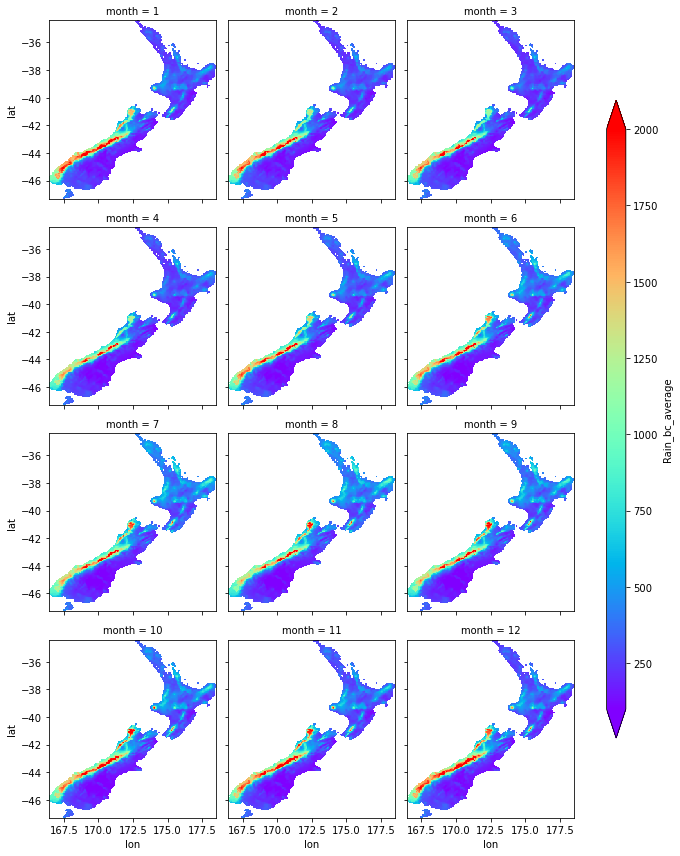

In [122]:
f = clim[f'{var_name}_average'].plot(x='lon', y='lat', col='month', col_wrap=3, vmin=100, vmax=2000, cmap=plt.cm.rainbow, cbar_kwargs={'shrink':0.8, 'aspect':30})

In [123]:
f.fig.savefig(f'./{var_name}_clim_average.png', dpi=200, bbox_inches='tight')

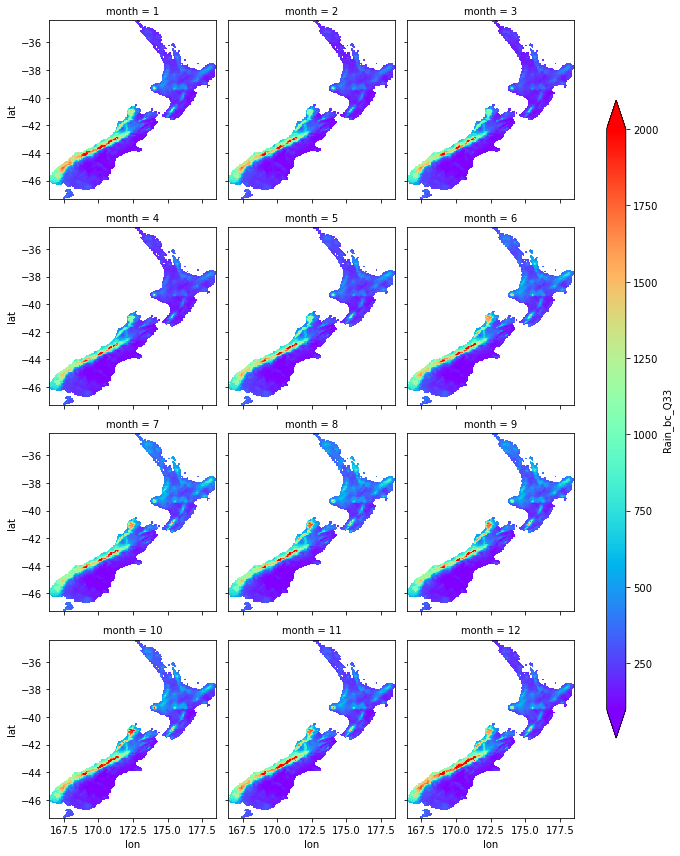

In [124]:
f = clim[f'{var_name}_Q33'].plot(x='lon', y='lat', col='month', col_wrap=3, vmin=100, vmax=2000, cmap=plt.cm.rainbow, cbar_kwargs={'shrink':0.8, 'aspect':30})

In [125]:
f.fig.savefig(f'./{var_name}_clim_Q33.png', dpi=200, bbox_inches='tight')

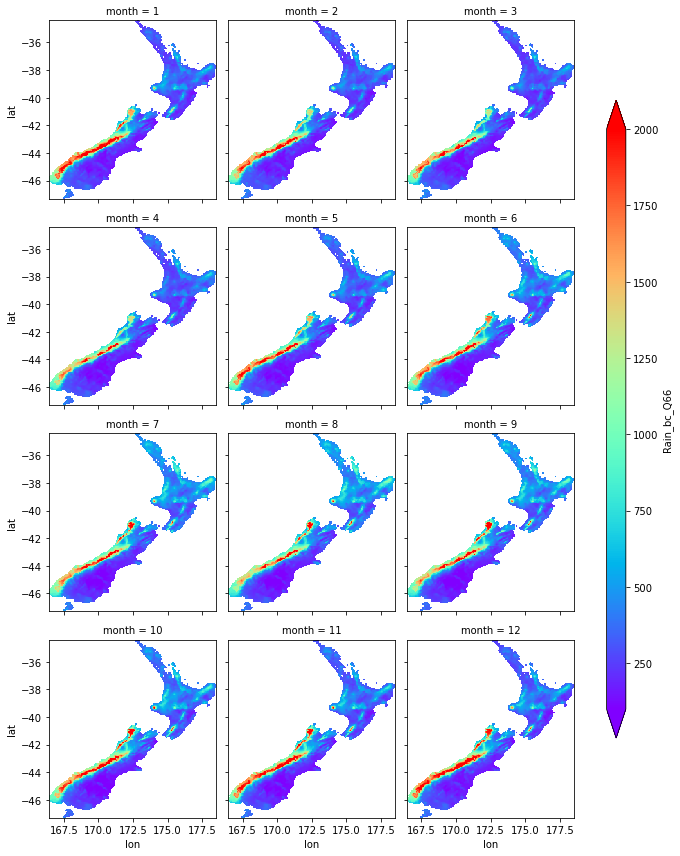

In [126]:
f = clim[f'{var_name}_Q66'].plot(x='lon', y='lat', col='month', col_wrap=3, vmin=100, vmax=2000, cmap=plt.cm.rainbow, cbar_kwargs={'shrink':0.8, 'aspect':30})

In [127]:
f.fig.savefig(f'./{var_name}_clim_Q66.png', dpi=200, bbox_inches='tight')

In [128]:
clim.to_netcdf(f'./climatology_average_Q33_Q66_{var_name}.nc')

### calculate pairwise distance 

In [132]:
ess = clim.isel(month=0)[['Rain_bc_average']]

In [135]:
ess = ess.stack(z=('lat','lon'))

In [175]:
ess = ess.dropna('z')

In [176]:
latlons = ess.z.data

In [177]:
latlons

array([(-47.275, 167.475), (-47.275, 167.525), (-47.225, 167.475), ...,
       (-34.475, 172.925), (-34.475, 172.975), (-34.425, 172.875)],
      dtype=object)

In [178]:
len(latlons)

11491

In [179]:
from sklearn.metrics.pairwise import haversine_distances

In [180]:
xy = np.array([np.array(x) for x in latlons])

In [181]:
from scipy.spatial.distance import cdist
from geopy.distance import distance as geodist # avoid naming confusion

In [182]:
import scipy

In [183]:
distances = scipy.spatial.distance.cdist(xy, xy)

In [184]:
distances.shape

(11491, 11491)

In [185]:
from math import  radians

In [187]:
xy

array([[-47.275, 167.475],
       [-47.275, 167.525],
       [-47.225, 167.475],
       ...,
       [-34.475, 172.925],
       [-34.475, 172.975],
       [-34.425, 172.875]])

In [192]:
xy_rad = np.array([np.array(list(map(radians, x))) for x in xy]) 

In [193]:
hav_distances = haversine_distances(xy_rad, xy_rad)

In [195]:
hav_distances_m = hav_distances * 6371000/1000

In [197]:
hav_distances_m

array([[   0.        ,    3.77217814,    5.55974633, ..., 1494.26597753,
        1495.5421319 , 1498.34657575],
       [   3.77217814,    0.        ,    6.71963901, ..., 1493.00038639,
        1494.26597753, 1497.09522517],
       [   5.55974633,    6.71963901,    0.        , ..., 1489.03242408,
        1490.31418654, 1493.10553119],
       ...,
       [1494.26597753, 1493.00038639, 1489.03242408, ...,    0.        ,
           4.58330611,    7.20625119],
       [1495.5421319 , 1494.26597753, 1490.31418654, ...,    4.58330611,
           0.        ,   10.72324027],
       [1498.34657575, 1497.09522517, 1493.10553119, ...,    7.20625119,
          10.72324027,    0.        ]])

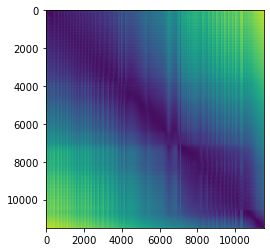

In [198]:
plt.imshow(hav_distances_m)

<xarray.Dataset>
Dimensions:          (lat: 257, lon: 241, month: 12)
Coordinates:
  * lon              (lon) float64 166.5 166.5 166.6 166.6 ... 178.4 178.4 178.5
  * lat              (lat) float64 -47.27 -47.23 -47.17 ... -34.52 -34.48 -34.42
  * month            (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Rain_bc_average  (month, lat, lon) float64 nan nan nan nan ... nan nan nan
    Rain_bc_Q33      (month, lat, lon) float64 nan nan nan nan ... nan nan nan
    Rain_bc_Q66      (month, lat, lon) float64 nan nan nan nan ... nan nan nan

In [17]:
nz_regions = gpd.read_file(HOME / 'research' / 'Smart_Ideas' / 'data' / 'shapefiles' / 'NZ_regions' / 'NZ_6_regions' / 'NZ_regions_corrected.shp') 

In [18]:
nz_regions

,OBJECTID,Id,gridcode,Shape_Leng,Shape_Area,Location,geometry
0,1,1,1,85.215338,5.032753,NNI,"MULTIPOLYGON (((174.70530 -38.17377, 174.70545..."
1,2,2,2,12.336015,2.994028,WNI,"MULTIPOLYGON (((175.13516 -41.37745, 175.13507..."
2,3,3,3,14.235493,3.775388,ENI,"MULTIPOLYGON (((175.85595 -41.35970, 175.85595..."
3,4,4,4,34.656463,3.066280,NSI,"MULTIPOLYGON (((171.32620 -42.12355, 171.32602..."
4,5,5,6,20.191504,4.827228,ESI,"MULTIPOLYGON (((170.21675 -46.05955, 170.21609..."
5,6,6,5,42.941379,9.057410,WSI,"MULTIPOLYGON (((169.20749 -46.66371, 169.20742..."


#### checks that the crs is correct: should be epsg 4272 

In [19]:
nz_regions.crs

<Geographic 2D CRS: EPSG:4272>
Name: NZGD49
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: New Zealand - onshore and nearshore
- bounds: (165.87, -47.65, 179.27, -33.89)
Datum: New Zealand Geodetic Datum 1949
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [20]:
opath_root = HOME / 'research' / 'Smart_Ideas' / 'outputs' / 'targets' / 'NZ_regions' / 'NZ_6_regions' / 'CLIOPS'

In [21]:
if not opath_root.exists(): 
    opath_root.mkdir(parents=True)

### defines the number of quantiles we want 

In [22]:
num_quantiles = 3

In [23]:
quant_values = np.linspace(0, 1, num_quantiles + 1, endpoint=True)

In [24]:
quant_values = quant_values[1:-1]

In [25]:
quant_values

array([0.33333333, 0.66666667])

In [26]:
col_labs = [f"Q{int(x)}" for x in (quant_values*100)]

In [27]:
col_labs

['Q33', 'Q66']

In [28]:
# %%writefile /home/nicolasf/research/Smart_Ideas/code/ml4seas/utils/calculate_quantiles.py
def calculate_quantiles(ts_series, quant_values): 
    
    """
    given one Pandas Series containing seasonally aggregated values (Note: NOT a dataframe) 
    and a list of quantiles, calculates the quantile category for each season 
    
    climatology by default is 1981 - 2010
    
    Parameters
    ----------
    
    - ts_series : a Pandas Series, with datetime index 
    - quant_values : a list of quantiles (e.g. [0.3333, 0.66666] for terciles)
    
    Return
    ------
    
    - ts_series_cat : a Pandas Series with the corresponding category 
    
    """
    
    ts_series_cat = []
    
    quantiles_list = []

    for month in range(1, 13):

        ts_series_m = ts_series[ts_series.index.month == month]

        clim = ts_series_m.loc['1981':'2010']

        quantiles = [clim.quantile(q=q) for q in quant_values.tolist()]

        quantiles_list.append(quantiles.copy())

        quantiles.insert(0, -np.inf)

        quantiles.append(np.inf)

        ts_series_m_cats = pd.cut(ts_series_m, quantiles, labels=list(range(1, num_quantiles + 1)))

        ts_series_cat.append(ts_series_m_cats)

        del(quantiles) 
        
    ts_series_cat = pd.concat(ts_series_cat)
    
    ts_series_cat = ts_series_cat.sort_index()
    
    return ts_series_cat 

In [29]:
# %%writefile /home/nicolasf/research/Smart_Ideas/code/ml4seas/utils/calculate_anomalies.py 
def calculate_anomalies(ts_series): 
    
    """
    given one Pandas Series containing seasonally aggregated values (Note: NOT a dataframe) 
    calculates the anomaly for each season 
    
    climatology by default is 1981 - 2010
    
    Parameters
    ----------
    
    - ts_series : a Pandas Series, with datetime index 
    
    Return
    ------
    
    - ts_series_anoms : Pandas Series with the corresponding anomalies 
    
    """
    
    def demean(x): 
        return x - x.loc['1981':'2010',].mean()
    
    ts_series_anoms = ts_series.groupby(ts_series.index.month).apply(demean) 
    
    ts_series_anoms = ts_series_anoms.sort_index()
    
    return ts_series_anoms


### loop over the regions 

In [30]:
for region_name in ['NNI','ENI','WNI','NSI','WSI','ESI']: 
    
    print(f"processing {region_name}")
    
    shape = nz_regions.query(f"Location == '{region_name}'")
    
    region = dset.salem.subset(shape=shape)
    
    region = region.salem.roi(shape=shape, all_touched=True)
    
    region_stacked = region.stack(z=('lat','lon'))
    
    region_stacked = region_stacked.dropna(dim='z')
    
    n_points = len(region_stacked.z) 
    
    df_cat = []
    df_anoms = []
    
    for z in region_stacked.z.data: 
    
        ts_series = region_stacked.sel(z=z).to_dataframe()[var_name]
    
        df_cat.append(calculate_quantiles(ts_series, quant_values))
    
        df_anoms.append(calculate_anomalies(ts_series)) 
        
    df_cat = pd.concat(df_cat, axis=1)
        
    df_anoms = pd.concat(df_anoms, axis=1) 
    
    df_cat = df_cat.sort_index() 
    
    df_anoms = df_anoms.sort_index() 
    
    df_anoms = df_anoms.mean(axis=1)
    
    df_anoms = df_anoms.to_frame(name='anoms')
        
    df_cat_freq = df_cat.apply(pd.value_counts, axis=1) / n_points
    
    df_cat_freq = df_cat_freq.fillna(value=0)
    
    df_cat_freq.loc[:,'cat_3'] = df_cat_freq.idxmax(axis=1)
    
    df_cat_freq.loc[:,'n_points'] = n_points
    
    df = pd.concat([df_cat_freq, df_anoms], axis=1)
    
    opath = opath_root / big_var / region_name 
    
    if not opath.exists(): 
        opath.mkdir(parents=True)
        
    fout = opath / f'TS_NZ_region_{region_name}_{big_var}_{num_quantiles}_quantiles_anoms_cliops.csv' 
    
    df.to_csv(fout)
    
    if fout.exists(): 
        print(f"successfully created {str(fout)}")

    else: 
        print(f"something went wrong trying to save {str(fout)}")

processing NNI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/NNI/TS_NZ_region_NNI_TMEAN_3_quantiles_anoms_cliops.csv
processing ENI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/ENI/TS_NZ_region_ENI_TMEAN_3_quantiles_anoms_cliops.csv
processing WNI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/WNI/TS_NZ_region_WNI_TMEAN_3_quantiles_anoms_cliops.csv
processing NSI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/NSI/TS_NZ_region_NSI_TMEAN_3_quantiles_anoms_cliops.csv
processing WSI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regions/NZ_6_regions/CLIOPS/TMEAN/WSI/TS_NZ_region_WSI_TMEAN_3_quantiles_anoms_cliops.csv
processing ESI
successfully created /home/nicolasf/research/Smart_Ideas/outputs/targets/NZ_regi

### EOF 